# NS Shop+편성데이터(NS홈쇼핑) 를 활용하여 방송편성표에 따른
# 판매실적을 예측하고, 최적 수익을 고려한 요일별/ 시간대별 / 카테고리별 편성
# 최적화 방안(모형) 제시

## 1. 라이브러리 임포트

In [3]:
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import SGD
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn.preprocessing as pp
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import sklearn.metrics as mt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

mpl.rcParams['font.family'] = 'Malgun Gothic'
%matplotlib inline
# 데이터 프레임 자리수 표기
# pd.options.display.float_format = '{:.5f}'.format

G:\Anaconda\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
G:\Anaconda\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## 2. 데이터 읽어오기

In [94]:
실적데이터1 = pd.read_excel(
    r'./01_제공데이터/2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터_v1_200818.xlsx', header=1)
시청률데이터1 = pd.read_excel(
    r'./01_제공데이터/2020 빅콘테스트 데이터분석분야-챔피언리그_시청률 데이터.xlsx', header=1)
평가데이터1 = pd.read_excel(
    r'./02_평가데이터/2020 빅콘테스트 데이터분석분야-챔피언리그_2020년 6월 판매실적예측데이터(평가데이터).xlsx', header=1)
기온데이터1 = pd.read_excel(
    r'./01_제공데이터/기온.xlsx', header=0, encoding='euc-kr')
강수량데이터1 = pd.read_excel(
    r'./01_제공데이터/강수량.xlsx', header=0, encoding='euc-kr')
풍속데이터1 = pd.read_excel(
    r'./01_제공데이터/풍속.xlsx', header=0, encoding='euc-kr')
주가데이터1 = pd.read_csv(
    r'./01_제공데이터/주가데이터.csv', header=0)

## 3. 기본 전처리 & 분석에 용이하게 컬럼 형태 변경

In [49]:
실적데이터=실적데이터1.copy()
시청률데이터=시청률데이터1.copy()
평가데이터=평가데이터1.copy()

# 데이터 전처리
실적데이터.rename(columns={'노출(분)' : '노출'}, inplace=True)

# 결측값 처리 
# 1. 판매단가가 0인 데이터 제거
실적데이터.취급액.fillna(0, inplace=True)

# 2. 노출값이 nan인 항목은 바로 위 항목으로 채우기
실적데이터.노출.fillna(method='ffill', inplace=True)

# 2019년 데이터만 분석할 예정 -> 2020년 데이터 제거(10개 내외)
실적데이터=실적데이터[실적데이터.방송일시<'2020-01-01']

# 판매가 0원인 상품 제거(무형)
실적데이터=실적데이터[실적데이터.판매단가!=0]

# 예측변수(종속변수)를 취급액 대신 주문량 사용
# 주문량 = 취급액 / 판매단가 round(x[1]/x[0], 3) if x[0]!=0 else 0
실적데이터['주문량'] = (실적데이터.취급액/실적데이터.판매단가).fillna(0)

# 방송일시 컬럼 나눠서 데이터형식 변경
실적데이터['월']=실적데이터.방송일시.dt.month
실적데이터['일']=실적데이터.방송일시.dt.day
실적데이터['요일']=실적데이터.방송일시.dt.weekday
실적데이터['주']=실적데이터.방송일시.dt.week
실적데이터['시간']=실적데이터.방송일시.dt.time
실적데이터['시']=실적데이터.방송일시.dt.hour
실적데이터['분']=실적데이터.방송일시.dt.minute

# 파생변수 생성 및 외부데이터 결합을 위한 추가변수 생성
실적데이터['방송날짜'] = 실적데이터.방송일시.apply(lambda x : str(x)).apply(lambda x : x.split(' ')[0])
실적데이터['방송시간'] = 실적데이터.방송일시.apply(lambda x : str(x)).apply(lambda x : x.split(' ')[1][:-3])

## 4. 외부데이터 추가

### 1) 날씨데이터

In [50]:
# 날씨 데이터 전처리
기온데이터=기온데이터1[['일시','평균최고기온(℃)', '평균최저기온(℃)']] #'평균기온(℃)',
강수량데이터=강수량데이터1[['일시','평균일강수량(mm)']] # ,'최다일강수량(mm)', '1시간최다강수량(mm)'
풍속데이터=풍속데이터1[['일시','최대풍속(m/s)']] # ,'평균풍속(m/s)', '최대순간풍속(m/s)'

기온데이터=기온데이터.sort_values(by='일시')
강수량데이터=강수량데이터.sort_values(by='일시')
풍속데이터=풍속데이터.sort_values(by='일시')

기온데이터.index=list(range(365))
강수량데이터.index=list(range(365))
풍속데이터.index=list(range(365))

기온데이터.일시=기온데이터.일시.map(lambda x : str(x).split(" ")[0])
강수량데이터.일시=강수량데이터.일시.map(lambda x : str(x).split(" ")[0])
풍속데이터.일시=pd.to_datetime(풍속데이터.일시).map(lambda x : str(x).split(" ")[0])

강수량데이터.fillna(0, inplace=True)

In [51]:
# 날씨데이터 합치기

실적데이터=실적데이터.rename(columns={'방송날짜':'일시'})

실적데이터=pd.merge(실적데이터, 기온데이터, on='일시')
실적데이터=pd.merge(실적데이터, 강수량데이터, on='일시')
실적데이터=pd.merge(실적데이터, 풍속데이터, on='일시')

### 2) 시청률데이터

In [52]:
# 시청률데이터 전처리
시청률데이터.set_index('시간대', inplace=True)
시청률데이터.rename(columns={'2019-01-01 to 2019-12-31' : '년평균'}, inplace=True)
시청률데이터.rename(index={'월화수목금토일02:00-01:59' : '일평균'}, inplace=True)
시청률데이터2 = 시청률데이터.loc[:"01:59",:"2019-12-31"]

In [53]:
# 각 방송일시별 분당평균시청률 구하기
분당평균시청률=[]
for i in range(len(실적데이터)):
    시작=실적데이터.방송시간.iloc[i]
    종료=str(pd.to_datetime(실적데이터.방송시간.iloc[i])+datetime.timedelta(minutes=round(float(실적데이터.노출.iloc[i]),0)-1)).split(" ")[1][:-3]
    분당평균시청률.append((시청률데이터2[실적데이터.일시.iloc[i]].loc[시작:종료].mean()))
    
분당최고시청률=[]
for i in range(len(실적데이터)):
    시작=실적데이터.방송시간.iloc[i]
    종료=str(pd.to_datetime(실적데이터.방송시간.iloc[i])+datetime.timedelta(minutes=round(float(실적데이터.노출.iloc[i]),0)-1)).split(" ")[1][:-3]
    분당최고시청률.append((시청률데이터2[실적데이터.일시.iloc[i]].loc[시작:종료].max()))

# 분당평균시청률
실적데이터['분당평균시청률']=분당평균시청률
실적데이터['분당최고시청률']=분당최고시청률

### 3) 주가데이터

In [54]:
주가데이터 = 주가데이터1.sort_values(by = '날짜')

# 2019년 00월 00일 리스트 생성
a = []
for i in range(13):
    if i in [1, 3, 5, 7, 8, 10, 12]:
        for j in range(1, 32):
            if i < 10:
                s1 = '0'+ str(i)
            else:
                s1 = str(i)
            if j < 10:
                s2 = '0'+ str(j)
            else:
                s2 = str(j)
            a.append("2019년 {}월 {}일".format(s1, s2))
    elif i in [4, 6, 9, 11]:
        for j in range(1, 31):
            if i < 10:
                s1 = '0'+ str(i) 
            else:
                s1 = str(i)
            if j < 10:
                s2 = '0'+ str(j)
            else:
                s2 = str(j)
            a.append("2019년 {}월 {}일".format(s1, s2))
    elif i == 2:
        for j in range(1, 29):
            if i < 10:
                s1 = '0'+ str(i) 
            else:
                s1 = str(i)
            if j < 10:
                s2 = '0'+ str(j)
            else:
                s2 = str(j)
            a.append("2019년 {}월 {}일".format(s1, s2))

# 주가데이터의 빈 날짜를 a 리스트와 merge를 통해 채움
# 날짜 위에서 아래로 1월 1일 ~ 12월 31일
a=pd.DataFrame(a)
a.columns=['날짜']
주가데이터2 = pd.merge(주가데이터, a, on='날짜', how='outer')
주가데이터2 = 주가데이터2.sort_values(by='날짜')

# 주가데이터 빈 행은 위아래 행으로 채움
주가데이터2 = 주가데이터2.fillna(method = 'ffill')
주가데이터2 = 주가데이터2.fillna(method = 'bfill')

# 거래량 K 지우고 1000해서 구함
주가데이터2.거래량=주가데이터2.거래량.map(lambda x : x[:-1])
주가데이터2.거래량=pd.to_numeric(주가데이터2.거래량)
주가데이터2.거래량=주가데이터2.거래량*1000

temp = pd.concat([실적데이터.pivot_table(index=['월','일'], values='주문량', aggfunc='mean').reset_index(), 주가데이터2.종가], axis=1)
temp.종가 = pd.to_numeric(temp.종가.map(lambda X: X.replace(",","")))

temp.drop(['주문량'], axis=1, inplace=True)

실적데이터=pd.merge(실적데이터, temp, on=['월','일'], how='outer')

## 5. 파생변수 생성

In [10]:
# 평일/주말, 수목금토
# 실적데이터['주말']=실적데이터.요일.map(lambda x :1 if x in [5,6] else 0)
# 실적데이터['수목금토']=실적데이터.요일.map(lambda x :1 if x in [2,3,4,5] else 0)

# 일
# 실적데이터['월말초'] = 실적데이터.일.map(lambda X: X in [1,2,3,4,5,6,26,27,28,29,30,31]).map(lambda X: 1 if X else 0)
# 실적데이터['26-28']=실적데이터.일.map(lambda x :1 if x in [26,27,28] else 0)

# 시간대별 상품군별 평균 주문량의 추세를 비교. 밤/새벽(19-02), 오전(6-12), 오후(12-19) 컬럼 생성
# 실적데이터['밤/새벽(19-02)']=실적데이터.시.map(lambda x : 1 if x <= 2 or x >= 19 else 0)
# 실적데이터['오전(6-12)']=실적데이터.시.map(lambda x : 1 if 6 <= x <= 12 else 0)
# 실적데이터['오후(12-19)']=실적데이터.시.map(lambda x : 1 if 12 < x < 19 else 0)

# 10-15,20이후
# 실적데이터['10-15,20이후']=실적데이터.시.map(lambda x : 1 if 10 <= x <= 15 or x >= 20 else 0)

# 3시간 단위
# 실적데이터['0-2시']=실적데이터.시.map(lambda x : 1 if 0 <= x < 3 else 0)
# 실적데이터['3-5시']=실적데이터.시.map(lambda x : 1 if 3 <= x < 5 else 0)
# 실적데이터['6-8시']=실적데이터.시.map(lambda x : 1 if 6 <= x < 9 else 0)
# 실적데이터['9-11시']=실적데이터.시.map(lambda x : 1 if 9 <= x < 12 else 0)
# 실적데이터['12-14시']=실적데이터.시.map(lambda x : 1 if 12 <= x < 15 else 0)
# 실적데이터['15-17시']=실적데이터.시.map(lambda x : 1 if 15 <= x < 18 else 0)
# 실적데이터['18-20시']=실적데이터.시.map(lambda x : 1 if 18 <= x < 21 else 0)
# 실적데이터['21-23시']=실적데이터.시.map(lambda x : 1 if 21 <= x < 24 else 0)

#  7,8,9, 15-18
# 실적데이터['789,15-18']=실적데이터.시.map(lambda x :  1 if x in [7,8,9,15,16,17,18] else 0)

# 6시 부터 밤 9시
# 실적데이터['6-21시']=실적데이터.시.map(lambda x : 1 if 6 <= x < 22 else 0)

# 15-17
# 실적데이터['15-17시']=실적데이터.시.map(lambda x : 1 if 15 <= x < 18 else 0)

# 계절
# 실적데이터['봄']=실적데이터.월.map(lambda x : 1 if x in [3,4,5] else 0)
# 실적데이터['여름']=실적데이터.월.map(lambda x :  1 if x in [6,7,8] else 0)
# 실적데이터['가을']=실적데이터.월.map(lambda x :  1 if x in [9,10,11] else 0)
# 실적데이터['겨울']=실적데이터.월.map(lambda x :  1 if x in [12,1,2] else 0)

# 상하반기
# 실적데이터['상반기']=실적데이터.월.map(lambda x : 1 if  x in [1,2,3,4,5,6] else 0)

# 7,8,9월 추세에 따른
# 실적데이터['월789']=실적데이터.월.map(lambda x :  1 if x in [7,8,9] else 0)
# 6-10월
# 실적데이터['월610'] = 실적데이터.월.map(lambda X: X in [6,7,8,9,10]).map(lambda X: 1 if X else 0)
# 11-12월
# 실적데이터['월1112'] = 실적데이터.월.map(lambda X: X in [11,12]).map(lambda X: 1 if X else 0)


# 실적데이터['월6-10']=실적데이터.월.map(lambda x :  1 if x in [6,7,8,9,10] else 0)
# 실적데이터['월11-12']=실적데이터.월.map(lambda x :  1 if x in [11,12] else 0)

# 노출
# 실적데이터['노출20미만']=실적데이터.노출.map(lambda x : 1 if x < 20 else 0)
# 실적데이터['노출20이상']=실적데이터.노출.map(lambda x : 1 if 20 <= x < 30 else 0)
# 실적데이터['노출30이상']=실적데이터.노출.map(lambda x : 1 if x >= 30 else 0)

# 주
# 실적데이터['주32이상']=실적데이터.주.map(lambda x : 1 if x >= 32 else 0)

# 168시간 기준
# 실적데이터['168시간기준']=실적데이터.방송일시.dt.weekday*24+실적데이터.방송일시.dt.hour

# 판매단가 분포에 따른 분류
# 실적데이터['저가'] = 실적데이터.판매단가.map(lambda X: 1 if X <=30000 else 0)
# 실적데이터['중가'] = 실적데이터.판매단가.map(lambda X: 1 if 30000< X <= 400000  else 0)
# 실적데이터['고가'] = 실적데이터.판매단가.map(lambda X: 1 if X >400000  else 0)

In [55]:
# 브랜드 컬럼

# 상품명에서 불필요한 단어 제거
list1 = []
for item in 실적데이터[['상품명']].values:
    for i in ['(직매입)', '일시불', '무이자', '도냄', 'a4', '뉴', '(일)', '(무)', '특집', '(쿠)',
              '초특가''(세일20%)', '1세트', '2세트', '(더블+더블)', '(더블+싱글)', '(더블사이즈)', 
              '(싱글사이즈)', '(점보특대형)', '(점보형)', '(중형)', '(퀸+퀸)', '(퀸+싱글)', '(싱글+싱글)', 
              '(킹사이즈)', '(퀸사이즈)', '[완벽더블]', '파격가', '초특가', '무)', '(렌탈)', '국내산']:
        item[0] = item[0].replace(i, "")
    list1.append(item[0].strip())

# 숫자, 영어, 한글을 제외한 문자 제거
list3 = []
for i in list1:
    result_string = ""
    for c in i:
        if c == " ":
            result_string += c
        elif c.isalnum():
            result_string += c
    list3.append(result_string.strip())

# 주로 브랜드명이 첫 어절에 온다고 판단. 첫 어절로 브랜드 컬럼 생성
list4 = []
for item in list3:
    list4.append(item.split(" ")[0])
실적데이터['브랜드'] = pd.Series(list4)

# 브랜드별 점수 매기기
# 브랜드별 평균 주문량 계산
df_temp = 실적데이터.pivot_table(
    index=['브랜드'], values='주문량', aggfunc='count').sort_values(by='주문량', ascending=False)
# minmaxscaler로 0~1 사이값으로 scale 조정
df_temp1 = pd.DataFrame(
    MinMaxScaler().fit_transform(df_temp), index=df_temp.index)

# 브랜드별 평균 주문량을 scale 조절한 값을 브랜드 점수로 산정. 브랜드점수 컬럼 생성
df_temp1 = df_temp1.reset_index()
실적데이터 = pd.merge(실적데이터, df_temp1, on='브랜드')
실적데이터.rename({0: '브랜드점수'}, axis=1, inplace=True)

## 5-1. 파생변수 생성을 위한 그래프 분석

### 1) 시간별 상품군별 주문량/방송횟수 비교

In [100]:
상품별_시간별_주문량=실적데이터.pivot_table(index=['시'],columns='상품군',values='주문량', aggfunc='mean')
상품별_시간별_갯수=실적데이터.pivot_table(index=['시'],columns='상품군',values='주문량', aggfunc='count')
상품별_시간별_주문량.fillna(0, inplace=True)
상품별_시간별_갯수.fillna(0, inplace=True)

# 비어있는 시간 제거 후 시간별 재정리
temp1=상품별_시간별_주문량.loc[6:23]
temp2=상품별_시간별_주문량.loc[0:2]
상품별_시간별_주문량=pd.concat([temp1,temp2], axis=0)
temp1=상품별_시간별_갯수.loc[6:23]
temp2=상품별_시간별_갯수.loc[0:2]
상품별_시간별_갯수=pd.concat([temp1,temp2], axis=0)

G:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
G:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


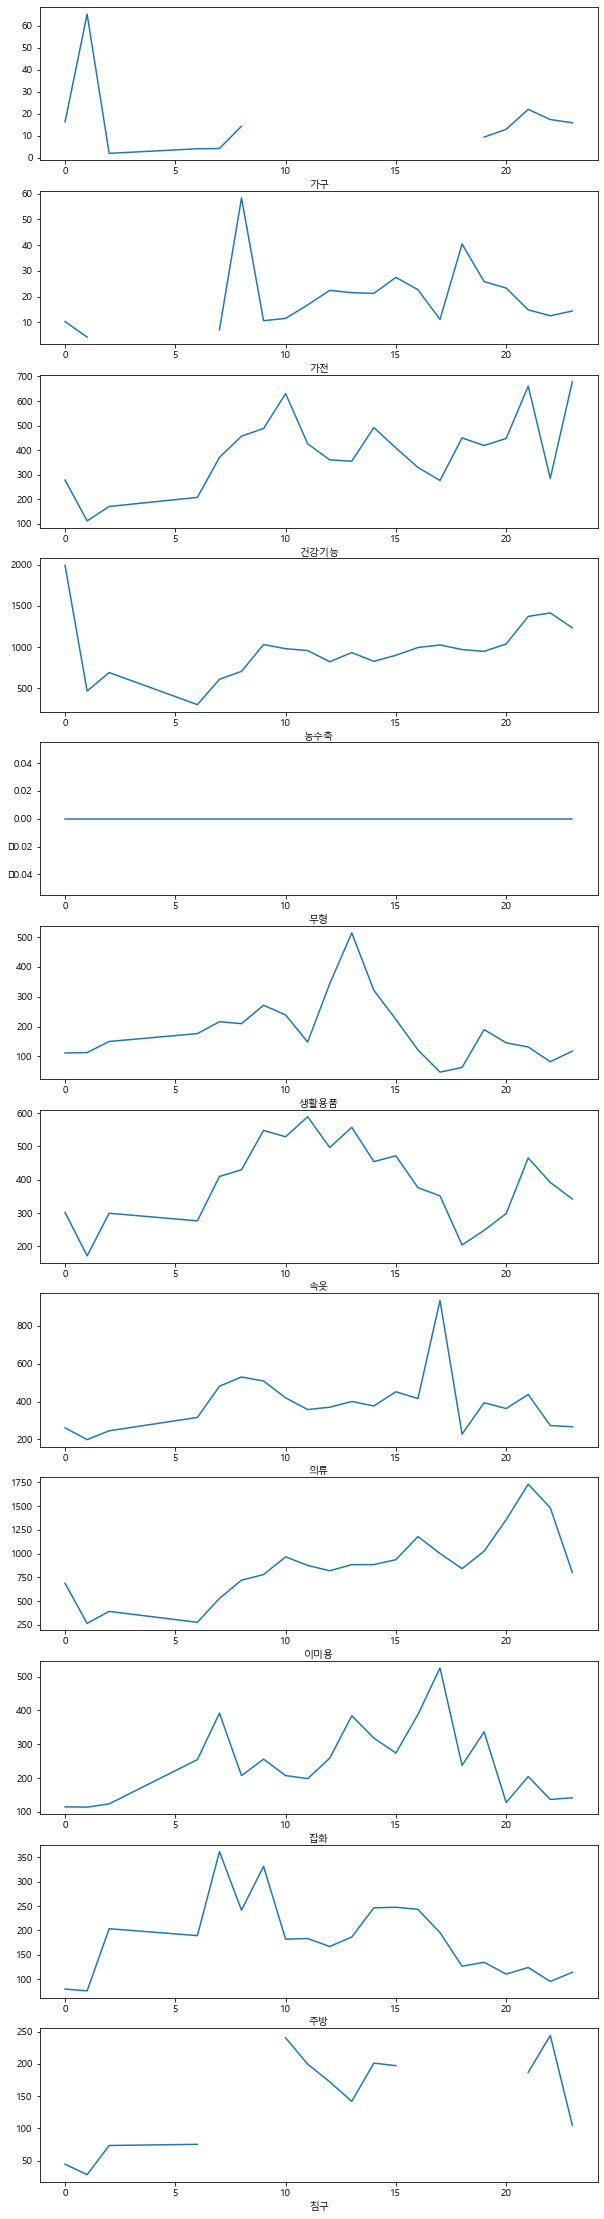

In [103]:
# 상품별 시간별 평균 주문량 그래프
plt.figure(figsize=(10,40))
for i, item in enumerate(list(상품별_시간별_주문량.columns)):
    plt.subplot(12,1,i+1)
    상품별_시간별_주문량[item].plot(kind='bar')
    plt.xlabel(item)
plt.savefig('상품별 시간별 평균 주문량.png')

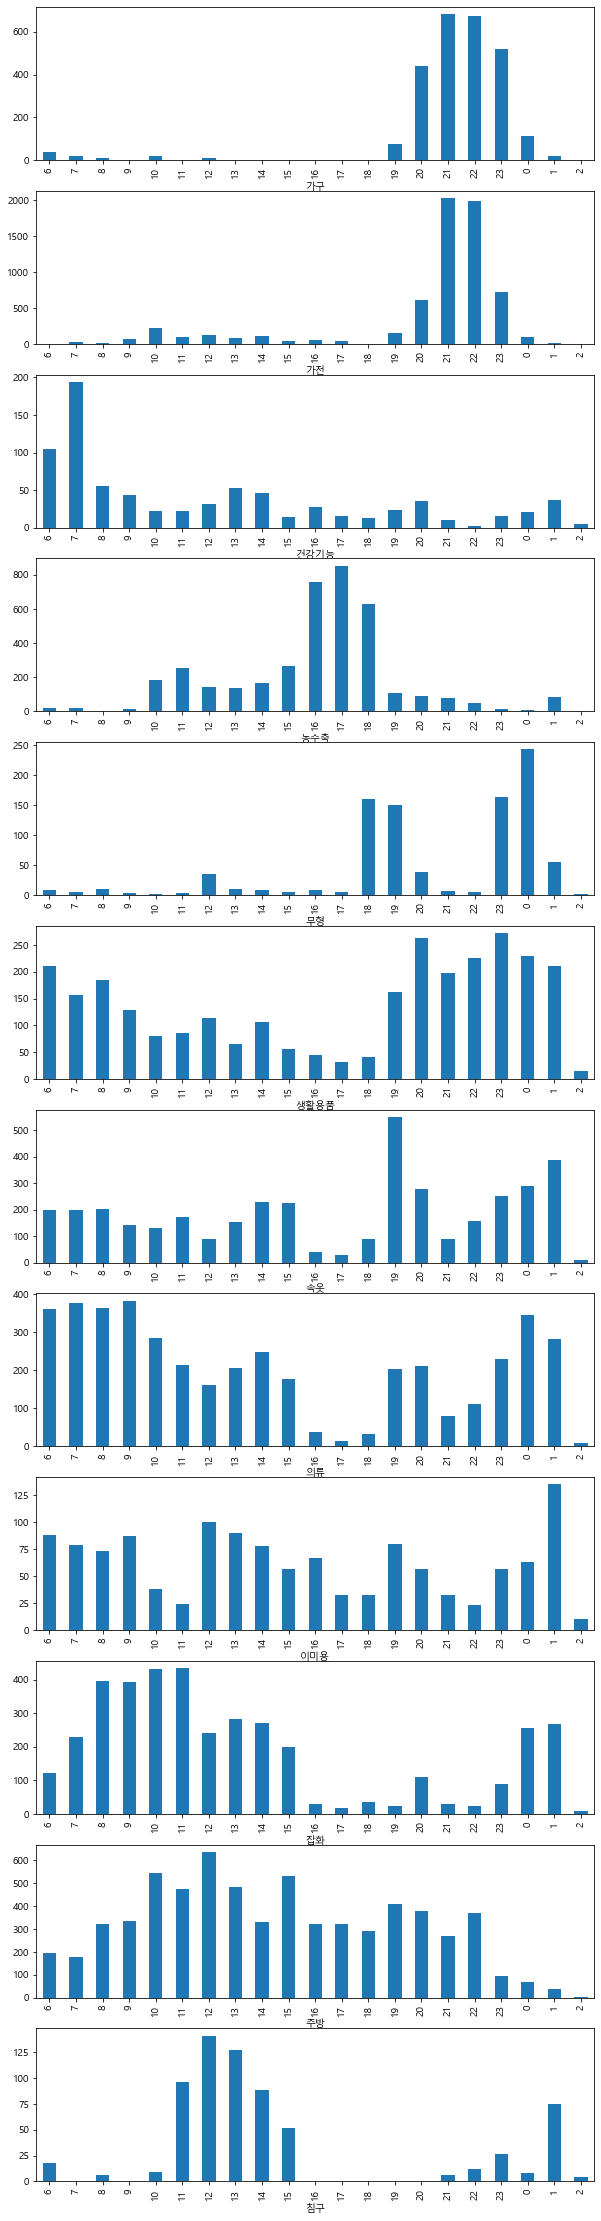

In [248]:
# 상품군별 시간별 방송횟수 그래프
plt.figure(figsize=(10,40))
for i, item in enumerate(list(상품별_시간별_갯수.columns)):
    plt.subplot(12,1,i+1)
    상품별_시간별_갯수[item].plot(kind='bar')
    plt.xlabel(item)
plt.savefig('상품군별 시간별 방송횟수.png')

### 2) 요일별 상품군별 주문량 비교

In [209]:
상품별_요일별_주문량=실적데이터.pivot_table(index=['요일'],columns='상품군',values='주문량', aggfunc='mean')
상품별_요일별_주문량.fillna(0, inplace=True)

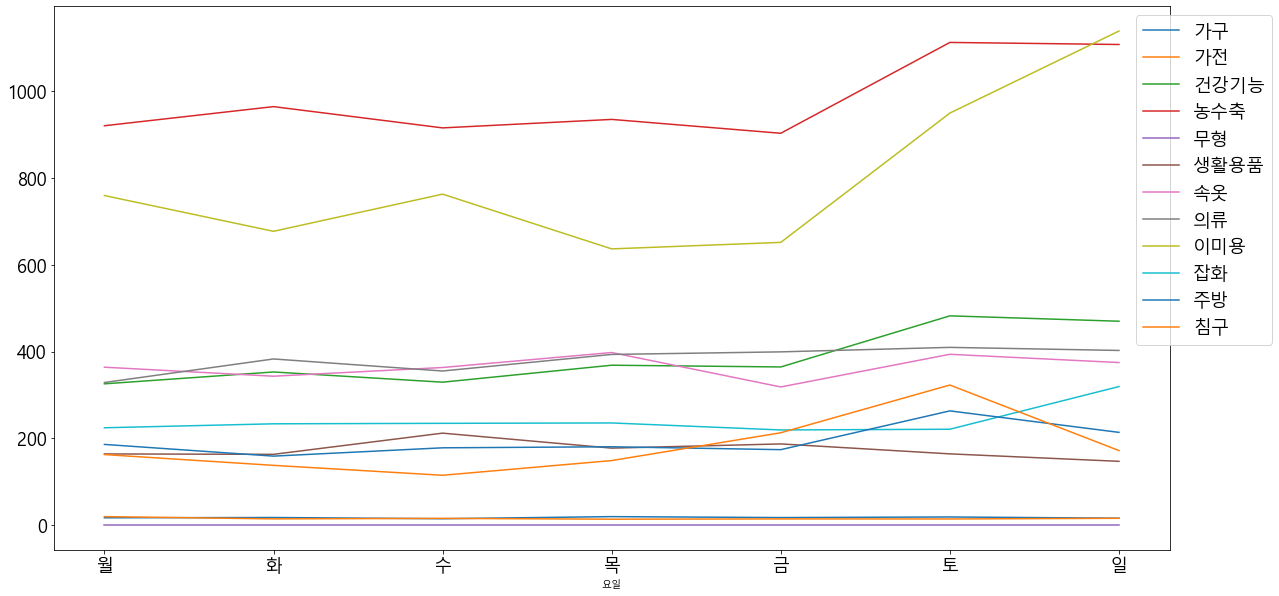

In [235]:
# 상품별 요일별 평균 주문량 그래프
상품별_요일별_주문량.plot(kind='line',figsize=(20,10), fontsize=18)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1), fontsize=18)
plt.xticks([0,1,2,3,4,5,6],['월','화','수','목','금','토','일'])
plt.savefig('상품군별 요일별 평균 주문량.png')

### 3) 월별 상품군별 주문량 비교

In [13]:
상품별_월별_주문량=실적데이터.pivot_table(index=['월'],columns='상품군',values='주문량', aggfunc='mean')
상품별_월별_주문량.fillna(0, inplace=True)

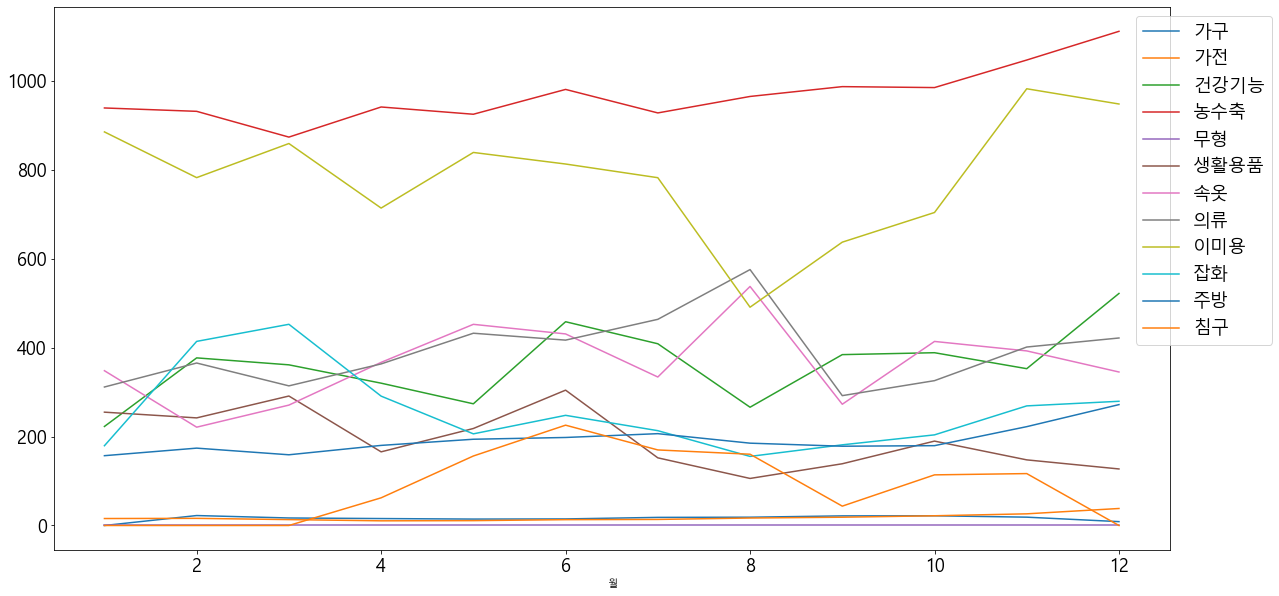

In [14]:
# 상품별 요일별 평균 주문량 그래프
상품별_월별_주문량.plot(kind='line',figsize=(20,10), fontsize=18)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1), fontsize=18)
plt.savefig('상품군별 월별 평균 주문량.png')

### 4) 주별 상품군별 주문량 비교

In [15]:
상품별_주별_주문량=실적데이터.pivot_table(index=['주'],columns='상품군',values='주문량', aggfunc='mean')
상품별_주별_주문량.fillna(0, inplace=True)

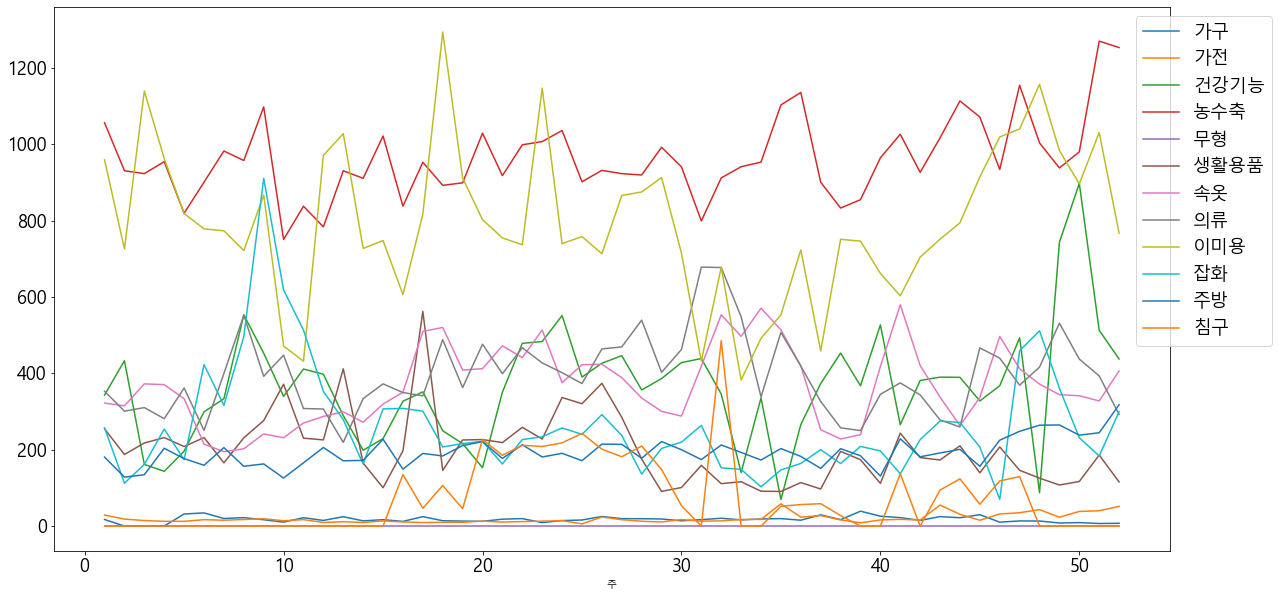

In [16]:
# 상품별 주별 평균 주문량 그래프
상품별_주별_주문량.plot(kind='line',figsize=(20,10), fontsize=18)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1), fontsize=18)
plt.savefig('상품군별 주별 평균 주문량.png')

### 5) 상품가격대별 주문량 비교

In [59]:
상품가격 = pd.qcut(실적데이터.판매단가,4)
le = pp.LabelEncoder()
상품가격대 = le.fit_transform(상품가격)
실적데이터['상품가격대'] = 상품가격대
shuffledSplit = StratifiedShuffleSplit(test_size=0.3)

for train_idx, test_idx in shuffledSplit.split(실적데이터, 실적데이터.상품가격대):
    train_set = 실적데이터.loc[train_idx]
    test_set = 실적데이터.loc[test_idx]

train_set.drop('상품가격대', axis=1, inplace=True)
test_set.drop('상품가격대', axis=1, inplace=True)

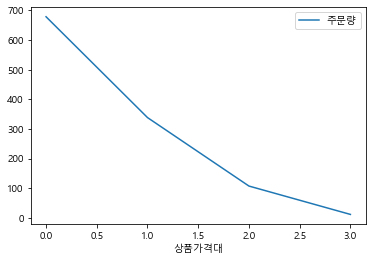

In [22]:
상품가격대별_주문량=실적데이터.pivot_table(index=['상품가격대'],values='주문량', aggfunc='mean')
상품가격대별_주문량.fillna(0, inplace=True)
상품가격대별_주문량.plot(kind='line')
plt.savefig('상품가격대별 평균 주문량.png')

### 6) 상품별 판매단가 분포 그래프

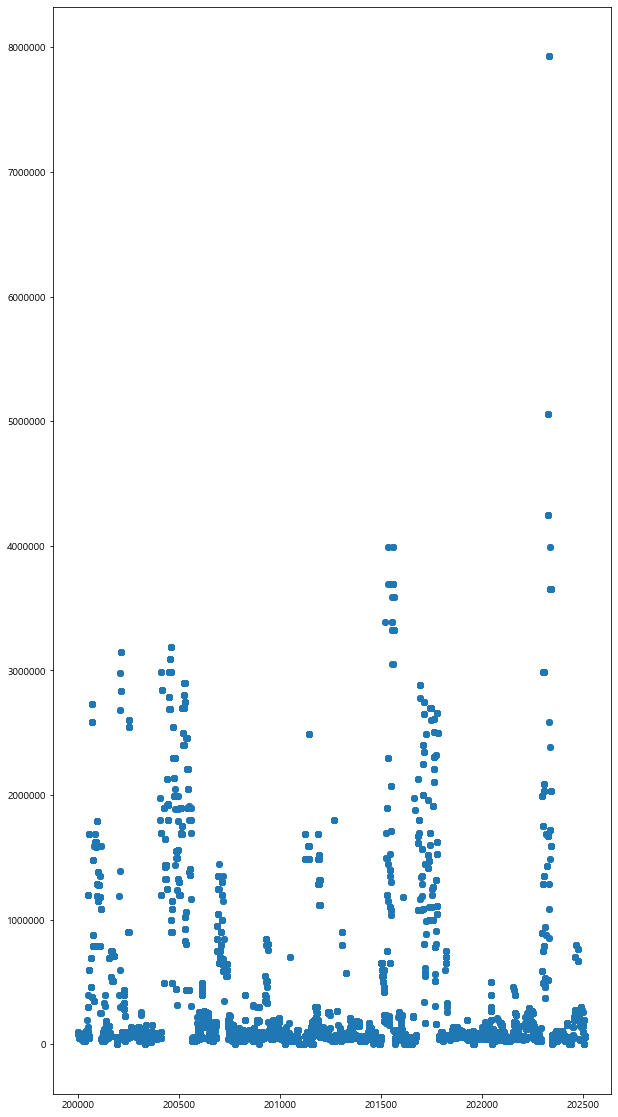

In [30]:
plt.figure(figsize=(10,20))
plt.scatter(실적데이터.상품코드, 실적데이터.판매단가)
plt.savefig('상품별 판매단가 분포 그래프.png')

### 7) 상품별 노출시간 분포 그래프

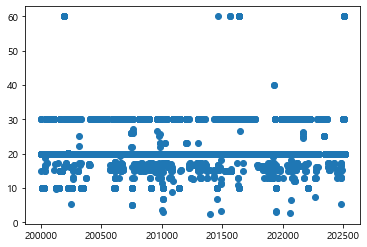

In [32]:
plt.scatter(실적데이터.상품코드, 실적데이터.노출)
plt.savefig('상품별 노출시간 분포 그래프.png')

### 8) 상품별 방송시간대 분포 그래프

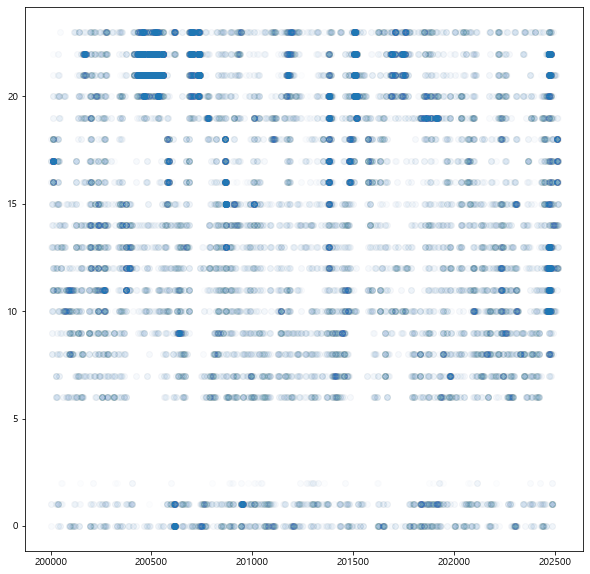

In [33]:
plt.figure(figsize=(10, 10))
plt.scatter(실적데이터.상품코드, 실적데이터.시, alpha=0.01)
plt.savefig('상품별 방송시간 분포 그래프.png')

### 9) 브랜드파워 그래프

In [ ]:
# 브랜드 파워 그래프
실적데이터.pivot_table(index=['브랜드'],values='주문량', aggfunc='mean').sort_values(by='주문량', ascending=False).plot(figsize=(15,10), kind='bar')
plt.savefig('브랜드파워 그래프.png')

## 6. 원핫인코딩

In [56]:
# 범주형 변수의 각 항목을 컬럼화

# 상품군
상품군_df=pd.get_dummies(실적데이터.상품군)
실적데이터=pd.concat([실적데이터, 상품군_df],axis=1)

# 마더코드
실적데이터.마더코드=실적데이터.마더코드-100000

마더코드_df=pd.get_dummies(실적데이터.마더코드)
마더코드=[]
마더코드_max=실적데이터.마더코드.max()
마더코드1=[str(i)+"마더코드" for i in range(0,마더코드_max+1)]
for i in 마더코드_df.columns:
    마더코드.append(str(i)+'마더코드')
마더코드_df.columns=마더코드
for i in [item for item in 마더코드1 if item not in 마더코드]:
    마더코드_df[i]=[0 for i in range(len(실적데이터))]
마더코드_df=마더코드_df[마더코드1]
실적데이터=pd.concat([실적데이터, 마더코드_df],axis=1)

# 상품코드
실적데이터.상품코드=실적데이터.상품코드-200000

상품코드_df=pd.get_dummies(실적데이터.상품코드)
상품코드=[]
상품코드_max=실적데이터.상품코드.max()
상품코드1=[str(i)+"상품코드" for i in range(0,상품코드_max+1)]
for i in 상품코드_df.columns:
    상품코드.append(str(i)+'상품코드')
상품코드_df.columns=상품코드
for i in [item for item in 상품코드1 if item not in 상품코드]:
    상품코드_df[i]=[0 for i in range(len(실적데이터))]
상품코드_df=상품코드_df[상품코드1]
실적데이터=pd.concat([실적데이터, 상품코드_df],axis=1)

# 월
월_df=pd.get_dummies(실적데이터.월)
월=[]
월1=[str(i)+"월" for i in range(1,13)]
for i in 월_df.columns:
    월.append(str(i)+'월')
월_df.columns=월
for i in [item for item in 월1 if item not in 월]:
    월_df[i]=[0 for i in range(len(실적데이터))]
월_df=월_df[월1]
실적데이터=pd.concat([실적데이터, 월_df],axis=1)

#일
일_df=pd.get_dummies(실적데이터.일)
일=[]
일1=[str(i)+'일' for i in range(1,32)]
for i in 일_df.columns:
    일.append(str(i)+'일')
일_df.columns=일
for i in [item for item in 일1 if item not in 일]:
    일_df[i]=[0 for i in range(len(실적데이터))]
일_df=일_df[일1]
실적데이터=pd.concat([실적데이터, 일_df],axis=1)

#요일
요일_df=pd.get_dummies(실적데이터.요일)
요일=[]
요일1=['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']
for i in 요일_df.columns:
    요일.append(요일1[i])
요일_df.columns=요일
for i in [item for item in 요일1 if item not in 요일]:
    요일_df[i]=[0 for i in range(len(실적데이터))]
요일_df=요일_df[요일1]
실적데이터=pd.concat([실적데이터, 요일_df],axis=1)

#주
주_df=pd.get_dummies(실적데이터.주)
주=[]
주1=[str(i)+"주" for i in range(1,53)]
for i in 주_df.columns:
    주.append(str(i)+'주')
주_df.columns=주
for i in [item for item in 주1 if item not in 주]:
    주_df[i]=[0 for i in range(len(실적데이터))]
주_df=주_df[주1]
실적데이터=pd.concat([실적데이터, 주_df],axis=1)

#시
시_df=pd.get_dummies(실적데이터.시)
시=[]
시1=[str(i)+"시" for i in range(0,24)]
for i in 시_df.columns:
    시.append(str(i)+'시')
시_df.columns=시
for i in [item for item in 시1 if item not in 시]:
    시_df[i]=[0 for i in range(len(실적데이터))]
시_df=시_df[시1]
실적데이터=pd.concat([실적데이터, 시_df],axis=1)

#분
분_df=pd.get_dummies(실적데이터.분)
분=[]
분1=[str(i)+"분" for i in range(0,60,5)]
for i in 분_df.columns:
    분.append(str(i)+'분')
분_df.columns=분
for i in [item for item in 분1 if item not in 분]:
    분_df[i]=[0 for i in range(len(실적데이터))]
분_df=분_df[분1]
실적데이터=pd.concat([실적데이터, 분_df],axis=1)

# 그외 데이터 스케일링(단위 낮춤)
실적데이터.판매단가=실적데이터.판매단가/100000
실적데이터.종가=실적데이터.종가/10000
실적데이터.노출=실적데이터.노출/60

# 필요없는 변수 삭제
실적데이터.drop(['마더코드', '상품코드', '월', '일', '요일', '주' , '시', '분','상품군'], axis=1, inplace=True)

In [58]:
# 필요없는 변수 삭제
실적데이터.drop(['평균최고기온(℃)', '평균최저기온(℃)', '평균일강수량(mm)', '최대풍속(m/s)', '분당평균시청률', '분당최고시청률',
            '종가', '취급액', '방송일시', '상품명', '일시', '브랜드', '시간', '방송시간','상품가격대'], axis=1, inplace=True)

In [61]:
# 종속변수와 독립변수 분리
X = 실적데이터.drop(['주문량'], axis=1)
y = 실적데이터['주문량']

## 7. 데이터 분석

In [62]:
# 학습, 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Random Forest

In [ ]:
rf_reg = RandomForestRegressor(max_depth=17, min_samples_leaf=3, min_samples_split=3,
                      n_estimators=800)
rf_reg.fit(X_train,y_train)

In [ ]:
y_pred=rf_reg.predict(X_test)
mse = mt.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = mt.r2_score(y_test, y_pred)
print(mse, rmse, r2)

### Regression Tree

In [ ]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train, y_train)

In [ ]:
y_pred=dt_reg.predict(X_test)
mse = mt.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = mt.r2_score(y_test, y_pred)
print(mse, rmse, r2)

### XGBOOST

In [63]:
xgb_reg = XGBRegressor(n_estimator = 500, gamma=0, learning_rate=0.4, max_depth=10, n_jobs=-1, objective ='reg:squarederror')
xgb_reg.fit(X_train, y_train)

XGBRegressor(learning_rate=0.4, max_depth=10, n_estimator=500, n_jobs=-1,
             objective='reg:squarederror')

In [64]:
y_pred=xgb_reg.predict(X_test)
mse = mt.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = mt.r2_score(y_test, y_pred)
print(mse, rmse, r2)

22483.25278292546 149.94416555146606 0.8699513578116382


### 다층신경망(MLPRegressor)

In [197]:
mlp = MLPRegressor(hidden_layer_sizes=(10,10,10), max_iter=200, solver='adam', objective ='reg:squarederror')
mlp.fit(X_train, y_train)

G:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[  68.9957217   506.73024355  813.11448224 ...   23.17368063   26.96283346
 1519.95966321]
24982.018404709623 158.05700998282114 0.861196545569298


In [ ]:
y_pred = mlp.predict(X_test)
mse = mt.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = mt.r2_score(y_test, y_pred)
print(mse, rmse, r2)

### AdaBoost

In [ ]:
ada_reg = AdaBoostRegressor(base_estimator=None, learning_rate=0.05, loss='exponential',
         n_estimators=100, random_state=0) 
ada_reg.fit(X_train, y_train)

In [ ]:
y_pred = mlp.predict(X_test)
mse = mt.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = mt.r2_score(y_test, y_pred)
print(mse, rmse, r2)

### LGBMRegressor

In [ ]:
lgbm_reg = LGBMRegressor()

X_trian1 = X_train.copy()
num = len(X_trian1.columns) # len 뽑아서 열을 숫자 형태로 바꿔줘야 모델 학습 가능
cols = []
for i in range(num):
        cols.append(str(i))
X_trian1.columns = cols

lgbm_reg.fit(X_trian1, y_train)

In [ ]:
y_pred = lgbm_reg.predict(X_test)
mse = mt.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = mt.r2_score(y_test, y_pred)
print(mse, rmse, r2)

###  인공신경망(Neural Network)

In [65]:
n=X_train.shape[1:]
model = keras.models.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=n, kernel_initializer='normal'),
    keras.layers.Dense(16, activation='relu', kernel_initializer='normal'),
    keras.layers.Dense(1)
])
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                112544    
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 113,089
Trainable params: 113,089
Non-trainable params: 0
_________________________________________________________________


In [66]:
history = model.fit(X_train, y_train, epochs=30, batch_size=10, validation_split=0.2, verbose=1)

Epoch 1/30
2242/2242 [==============================] - 4s 2ms/step - loss: 102552.8906 - mae: 170.9466 - val_loss: 43762.7500 - val_mae: 117.1662
Epoch 2/30
2242/2242 [==============================] - 3s 1ms/step - loss: 45427.1133 - mae: 105.3416 - val_loss: 32413.8203 - val_mae: 96.5417
Epoch 3/30
2242/2242 [==============================] - 3s 1ms/step - loss: 37311.0000 - mae: 91.2483 - val_loss: 27733.3594 - val_mae: 87.9366
Epoch 4/30
2242/2242 [==============================] - 3s 1ms/step - loss: 33394.4766 - mae: 84.5056 - val_loss: 25411.2285 - val_mae: 82.7342
Epoch 5/30
2242/2242 [==============================] - 3s 1ms/step - loss: 31170.8203 - mae: 80.4686 - val_loss: 24532.8086 - val_mae: 80.4140
Epoch 6/30
2242/2242 [==============================] - 3s 1ms/step - loss: 29784.5605 - mae: 77.7348 - val_loss: 24097.0762 - val_mae: 80.0052
Epoch 7/30
2242/2242 [==============================] - 3s 1ms/step - loss: 28780.9258 - mae: 75.7289 - val_loss: 23435.9180 - val_m

In [68]:
loss_and_metrics = model.evaluate(X_test, y_test)
print(f'\nLoss : {loss_and_metrics[0]:6}')
print(f'mae : {loss_and_metrics[1]:6}')

292/292 [==============================] - 0s 1ms/step - loss: 19071.7051 - mae: 66.4354

Loss : 19071.705078125
mae : 66.43535614013672


In [67]:
y_pred=model.predict(X_test)
mse = mt.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = mt.r2_score(y_test, y_pred)
print(mse, rmse, r2)

19071.707406480342 138.10035266602452 0.8896845720513326


## 8. GridSearchCV를 이용한 하이퍼파라미터 조정

### XGBRegressor

In [176]:
xgb_param = {
    'subsample': [0.4, 0.6],                   #  2
    'min_child_weight':[1, 5, 10],             #  3
    'gamma':[0.5, 1, 1.5, 2, 5],               #  4
    'max_depth':[4,10,15],                     #  3
    'eta':[0.05, 0.01,  0.1, 0.3]              #  4
}
xgb = XGBRegressor()
grid_xgb = GridSearchCV(xgb, param_grid=xgb_param, scoring='r2', cv=5)
grid_xgb.fit(X_train, y_train)

print('final params', grid_xgb.best_params_)   # 최적의 파라미터 값 출력
print('best score', grid_xgb.best_score_)      # 최고의 점수

In [182]:
y_pred=grid_xgb.predict(X_test)
mse = mt.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = mt.r2_score(y_test, y_pred)
print(mse, rmse, r2)

학습데이터 정확도  0.9894742456727855
테스트데이터 정확도 0.86


### RandomForest

In [ ]:
rf_reg = RandomForestRegressor()
rf_params = { 'n_estimators' : [700,800,1000],
           'max_depth' : [8,14,17],
           'min_samples_leaf' : [1,3],
           'min_samples_split' : [2,3,7]            }
grid_reg = GridSearchCV(rf_reg, param_grid = rf_params, scoring='r2',cv=5)
grid_reg.fit(X_train,y_train)

print('final params', grid_reg.best_params_)   # 최적의 파라미터 값 출력
print('best score', grid_reg.best_score_)      # 최고의 점수

In [ ]:
y_pred=grid_reg.predict(X_test)
mse = mt.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = mt.r2_score(y_test, y_pred)
print(mse, rmse, r2)

## 8-1. Kfold 교차검증(nn에 적용)

In [26]:
class nn_keras(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.data = None
        self.model = None
        self.result = None
        
    def fit(self, X_train, y_train):
        self.model = keras.models.Sequential([
                keras.layers.Dense(32, activation='relu', input_shape=X_train.shape[1:], kernel_initializer='normal'),
                keras.layers.Dense(16, activation='relu', kernel_initializer='normal'),
                keras.layers.Dense(1)
            ])
        self.model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mse', metrics=['mae'])
        self.result = self.model.fit(X_train, y_train, epochs=30, batch_size=10, validation_split=0.2, verbose=1)
        
    def predict(self, new_data):
        return self.model.predict(new_data)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
cv = KFold(5, shuffle=True, random_state=0)
model=nn_keras()
results = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
print("Results: %.3f (%.3f) MAE" % (results.mean(), results.std()))
print(results)

Epoch 1/30
1839/1839 [==============================] - 4s 2ms/step - loss: 116961.7266 - mae: 187.0342 - val_loss: 56528.9023 - val_mae: 128.5258
Epoch 2/30
1839/1839 [==============================] - 3s 2ms/step - loss: 48864.7695 - mae: 111.5802 - val_loss: 42259.7266 - val_mae: 104.1155
Epoch 3/30
1839/1839 [==============================] - 3s 2ms/step - loss: 39618.6719 - mae: 95.5947 - val_loss: 36659.0898 - val_mae: 93.7485
Epoch 4/30
1839/1839 [==============================] - 3s 1ms/step - loss: 34946.8516 - mae: 87.1583 - val_loss: 33190.5977 - val_mae: 87.7217
Epoch 5/30
1839/1839 [==============================] - 3s 2ms/step - loss: 32211.4180 - mae: 82.1767 - val_loss: 31136.9570 - val_mae: 85.2730
Epoch 6/30
1839/1839 [==============================] - 3s 1ms/step - loss: 30458.7188 - mae: 78.7791 - val_loss: 29835.0215 - val_mae: 82.2786
Epoch 7/30
1839/1839 [==============================] - 3s 2ms/step - loss: 29304.6855 - mae: 76.5222 - val_loss: 29047.3535 - val_

1839/1839 [==============================] - 3s 1ms/step - loss: 18702.6836 - mae: 54.6030 - val_loss: 18642.2695 - val_mae: 66.7607
Epoch 24/30
1839/1839 [==============================] - 3s 2ms/step - loss: 18220.1875 - mae: 53.9321 - val_loss: 18395.5273 - val_mae: 67.2009
Epoch 25/30
1839/1839 [==============================] - 3s 1ms/step - loss: 17916.2070 - mae: 52.8404 - val_loss: 18316.4277 - val_mae: 66.0868
Epoch 26/30
1839/1839 [==============================] - 3s 2ms/step - loss: 17660.9492 - mae: 52.0779 - val_loss: 18220.9707 - val_mae: 65.4968
Epoch 27/30
1839/1839 [==============================] - 3s 1ms/step - loss: 17240.1992 - mae: 51.2958 - val_loss: 19924.2188 - val_mae: 69.5560
Epoch 28/30
1839/1839 [==============================] - 3s 2ms/step - loss: 16922.2949 - mae: 51.0534 - val_loss: 18193.0117 - val_mae: 65.9535
Epoch 29/30
1839/1839 [==============================] - 3s 1ms/step - loss: 16638.6504 - mae: 50.1602 - val_loss: 18223.7090 - val_mae: 65.98

## 9. 평가데이터 예측 

In [69]:
# 데이터 전처리
평가데이터.rename(columns={'노출(분)' : '노출'}, inplace=True)

# 결측값 처리 
# 1. 판매단가가 0인 데이터 제거
평가데이터.취급액.fillna(0, inplace=True)

# 2. 노출값이 nan인 항목은 바로 위 항목으로 채우기
평가데이터.노출.fillna(method='ffill', inplace=True)

# 판매가 0워인 데이터 예측 제외
평가데이터=평가데이터[평가데이터.판매단가!=0]

# 날짜 컬럼 나누기
평가데이터['월']=평가데이터.방송일시.dt.month
평가데이터['일']=평가데이터.방송일시.dt.day
평가데이터['요일']=평가데이터.방송일시.dt.weekday
평가데이터['주']=평가데이터.방송일시.dt.week
평가데이터['시간']=평가데이터.방송일시.dt.time
평가데이터['시']=평가데이터.방송일시.dt.hour
평가데이터['분']=평가데이터.방송일시.dt.minute

# 실적데이터['시간'] = 실적데이터.시간.apply(lambda x : str(x)).apply(lambda x : int(x.split(':')[0])*60 + int(x.split(':')[1]))

평가데이터['방송날짜'] = 평가데이터.방송일시.apply(lambda x : str(x)).apply(lambda x : x.split(' ')[0])
평가데이터['방송시간'] = 평가데이터.방송일시.apply(lambda x : str(x)).apply(lambda x : x.split(' ')[1][:-3])

평가데이터 = 평가데이터.drop(['방송시간'],axis=1)
평가데이터=평가데이터.rename(columns={'방송날짜':'일시'})

In [70]:
# 브랜드 컬럼

# 상품명에서 불필요한 단어 제거
list1 = []
for item in 평가데이터[['상품명']].values:
    for i in ['(직매입)', '일시불', '무이자', '도냄', 'a4', '뉴', '(일)', '(무)', '특집', '(쿠)',
              '초특가''(세일20%)', '1세트', '2세트', '(더블+더블)', '(더블+싱글)', '(더블사이즈)', 
              '(싱글사이즈)', '(점보특대형)', '(점보형)', '(중형)', '(퀸+퀸)', '(퀸+싱글)', '(싱글+싱글)', 
              '(킹사이즈)', '(퀸사이즈)', '[완벽더블]', '파격가', '초특가', '무)', '(렌탈)', '국내산']:
        item[0] = item[0].replace(i, "")
    list1.append(item[0].strip())

# 숫자, 영어, 한글을 제외한 문자 제거
list3 = []
for i in list1:
    result_string = ""
    for c in i:
        if c == " ":
            result_string += c
        elif c.isalnum():
            result_string += c
    list3.append(result_string.strip())

# 주로 브랜드명이 첫 어절에 온다고 판단. 첫 어절로 브랜드 컬럼 생성
list4 = []
for item in list3:
    list4.append(item.split(" ")[0])
평가데이터['브랜드'] = pd.Series(list4)

# 브랜드별 점수 매기기
# 브랜드별 평균 주문량 계산
df_temp2 = 평가데이터.pivot_table(
    index=['브랜드'], values='판매단가', aggfunc='count').sort_values(by='판매단가', ascending=False)
# minmaxscaler로 0~1 사이값으로 scale 조정
df_temp3 = pd.DataFrame(
    MinMaxScaler().fit_transform(df_temp2), index=df_temp2.index)

# # 브랜드별 평균 주문량을 scale 조절한 값을 브랜드 점수로 산정. 브랜드점수 컬럼 생성
# df_temp1 = df_temp1.reset_index()
평가데이터 = pd.merge(평가데이터, df_temp1, on='브랜드')
평가데이터.rename({0: '브랜드점수'}, axis=1, inplace=True)

In [80]:
평가데이터_feature = 평가데이터.drop(['취급액', '방송일시', '상품명', '일시','브랜드','시간'], axis=1)
실적데이터_target= 실적데이터['주문량']

상품군_df=pd.get_dummies(평가데이터.상품군)
평가데이터=pd.concat([평가데이터, 상품군_df],axis=1)

평가데이터_feature.마더코드=평가데이터_feature.마더코드-100000
평가데이터_feature.상품코드=평가데이터_feature.상품코드-200000

마더코드_df=pd.get_dummies(평가데이터_feature.마더코드)
마더코드=[]
마더코드1=[str(i)+"마더코드" for i in range(0,마더코드_max+1)]
for i in 마더코드_df.columns:
    마더코드.append(str(i)+'마더코드')
마더코드_df.columns=마더코드
for i in [item for item in 마더코드1 if item not in 마더코드]:
    마더코드_df[i]=[0 for i in range(len(평가데이터_feature))]
마더코드_df=마더코드_df[마더코드1]
평가데이터_feature=pd.concat([평가데이터_feature, 마더코드_df],axis=1)

상품코드_df=pd.get_dummies(평가데이터_feature.상품코드)
상품코드=[]
상품코드1=[str(i)+"상품코드" for i in range(0,상품코드_max+1)]
for i in 상품코드_df.columns:
    상품코드.append(str(i)+'상품코드')
상품코드_df.columns=상품코드
for i in [item for item in 상품코드1 if item not in 상품코드]:
    상품코드_df[i]=[0 for i in range(len(평가데이터_feature))]
상품코드_df=상품코드_df[상품코드1]
평가데이터_feature=pd.concat([평가데이터_feature, 상품코드_df],axis=1)


월_df=pd.get_dummies(평가데이터_feature.월)
월=[]
월1=[str(i)+"월" for i in range(1,13)]
for i in 월_df.columns:
    월.append(str(i)+'월')
월_df.columns=월
for i in [item for item in 월1 if item not in 월]:
    월_df[i]=[0 for i in range(len(평가데이터_feature))]
월_df=월_df[월1]
평가데이터_feature=pd.concat([평가데이터_feature, 월_df],axis=1)

일_df=pd.get_dummies(평가데이터_feature.일)
일=[]
일1=[str(i)+'일' for i in range(1,32)]
for i in 일_df.columns:
    일.append(str(i)+'일')
일_df.columns=일
for i in [item for item in 일1 if item not in 일]:
    일_df[i]=[0 for i in range(len(평가데이터_feature))]
일_df=일_df[일1]
평가데이터_feature=pd.concat([평가데이터_feature, 일_df],axis=1)

요일_df=pd.get_dummies(평가데이터_feature.요일)
요일=[]
요일1=['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']
for i in 요일_df.columns:
    요일.append(요일1[i])
요일_df.columns=요일
for i in [item for item in 요일1 if item not in 요일]:
    요일_df[i]=[0 for i in range(len(평가데이터_feature))]
요일_df=요일_df[요일1]
평가데이터_feature=pd.concat([평가데이터_feature, 요일_df],axis=1)

주_df=pd.get_dummies(평가데이터_feature.주)
주=[]
주1=[str(i)+"주" for i in range(1,53)]
for i in 주_df.columns:
    주.append(str(i)+'주')
주_df.columns=주
for i in [item for item in 주1 if item not in 주]:
    주_df[i]=[0 for i in range(len(평가데이터_feature))]
주_df=주_df[주1]
평가데이터_feature=pd.concat([평가데이터_feature, 주_df],axis=1)

시_df=pd.get_dummies(평가데이터_feature.시)
시=[]
시1=[str(i)+"시" for i in range(0,24)]
for i in 시_df.columns:
    시.append(str(i)+'시')
시_df.columns=시
for i in [item for item in 시1 if item not in 시]:
    시_df[i]=[0 for i in range(len(평가데이터_feature))]
시_df=시_df[시1]
평가데이터_feature=pd.concat([평가데이터_feature, 시_df],axis=1)

분_df=pd.get_dummies(평가데이터_feature.분)
분=[]
분1=[str(i)+"분" for i in range(0,60,5)]
for i in 분_df.columns:
    분.append(str(i)+'분')
분_df.columns=분
for i in [item for item in 분1 if item not in 분]:
    분_df[i]=[0 for i in range(len(평가데이터_feature))]
분_df=분_df[분1]
평가데이터_feature=pd.concat([평가데이터_feature, 분_df],axis=1)


평가데이터_feature.판매단가=평가데이터_feature.판매단가/100000
평가데이터_feature.노출=평가데이터_feature.노출/60

평가데이터_feature = 평가데이터_feature.drop(['마더코드', '상품코드', '월', '일', '요일', '주' , '시', '분','상품군'], axis=1)

In [81]:
testX=평가데이터_feature.copy()

In [48]:
# 인공신경망을 이용하여 학습데이터를 학습 후 평가데이터 예측
n=X_train.shape[1:]
model = keras.models.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=n, kernel_initializer='normal'),
    keras.layers.Dense(16, activation='relu', kernel_initializer='normal'),
    keras.layers.Dense(1)
])
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mse', metrics=['mae'])
model.summary()
model.fit(X_train, y_train, epochs=30, batch_size=10, validation_split=0.2, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                112576    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 113,121
Trainable params: 113,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
2298/2298 [==============================] - 4s 2ms/step - loss: 104693.9375 - mae: 173.9916 - val_loss: 49846.9922 - val_mae: 115.8836
Epoch 2/30
2298/2298 [==============================] - 3s 2ms/step - loss: 44414.9102 - mae: 103.5260 - val_loss: 37120.0703 - val_mae: 94.7697
Epoch 3/30
2298/2298 [==============================] - 3s 1ms/step - loss: 36275.7891 -

In [84]:
y_pred=model.predict(testX)
평가데이터['주문량']=pd.DataFrame(y_pred, columns=['주문량'])
평가데이터['취급액']=평가데이터.주문량*평가데이터.판매단가

In [96]:
# 평가데이터 예측취급액 넣어서 저장
평가데이터2=평가데이터1.copy()
평가데이터2.drop('취급액',axis=1,inplace=True)
평가데이터2=pd.merge(평가데이터2,평가데이터[['방송일시','상품명','취급액']], on=['방송일시','상품명'], how='left')
평가데이터2.취급액.fillna(0, inplace=True)
평가데이터1.to_csv(r'./02_평가데이터/평가데이터_예측.csv', encoding='euc-kr')

## 10. 예측을 토대로 요일별 시간별 상품군별 최적방안 도출

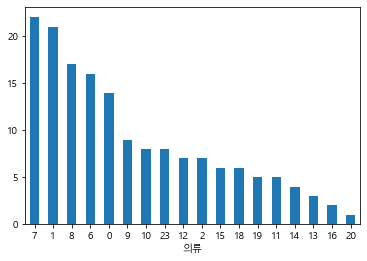

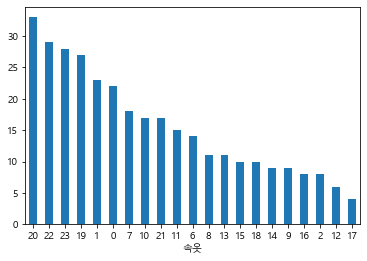

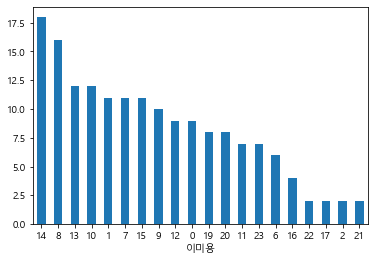

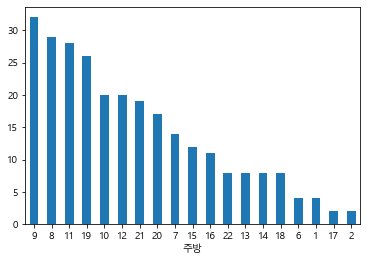

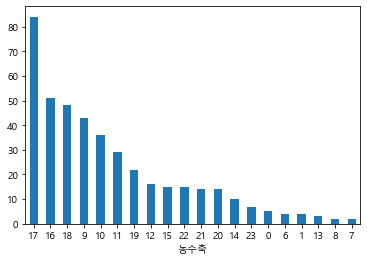

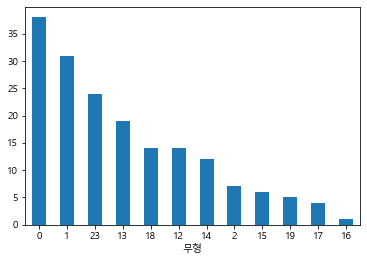

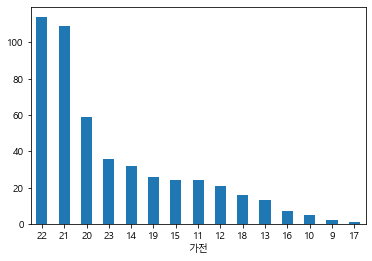

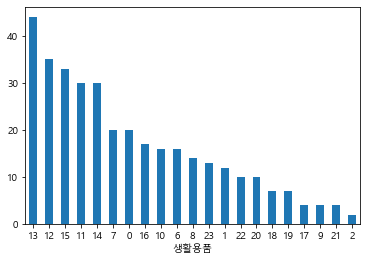

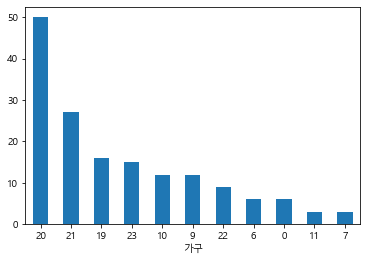

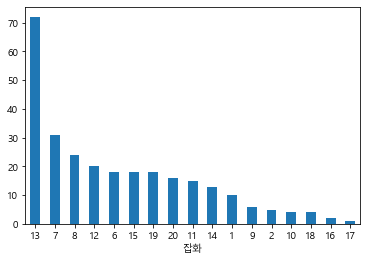

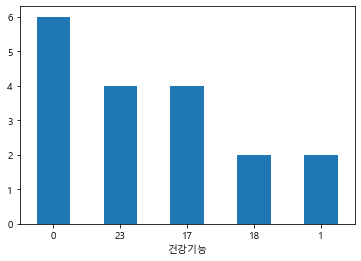

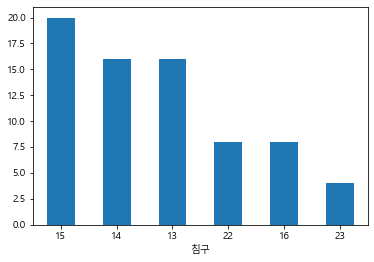

In [264]:
ratio25 = int(len(평가데이터) * 0.25)
for item in 평가데이터.상품군.unique():
    plt.figure()
    평가데이터[평가데이터.상품군 == item].sort_values(by='취급액', ascending=False).시[:ratio25].value_counts().plot(kind='bar')
    plt.xticks(rotation=0)
    plt.xlabel(item)
    plt.savefig('data/{}시간.png'.format(item))

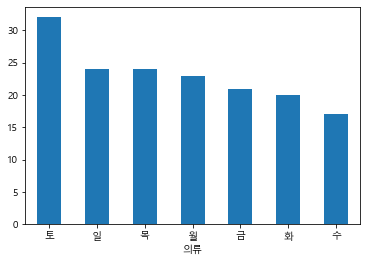

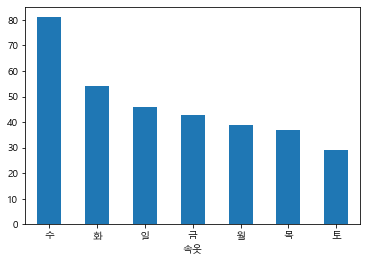

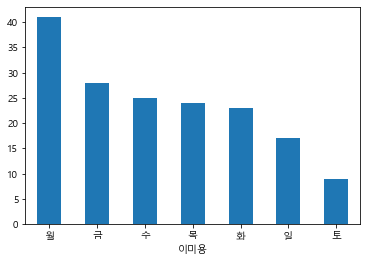

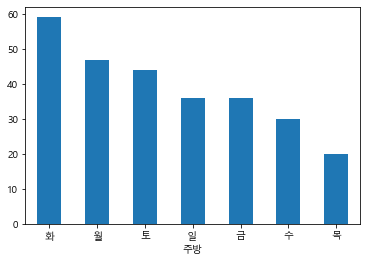

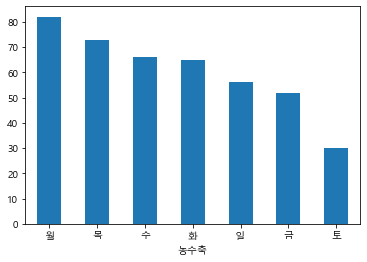

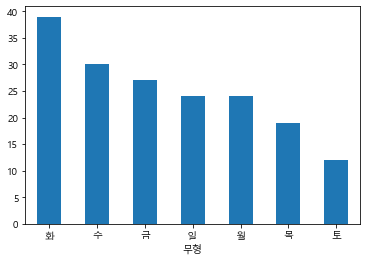

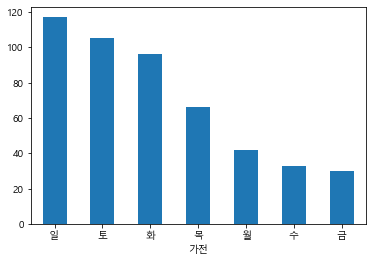

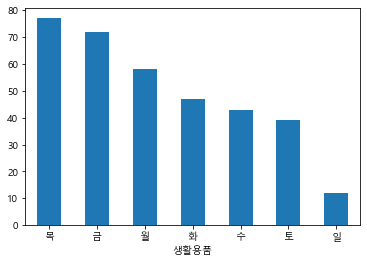

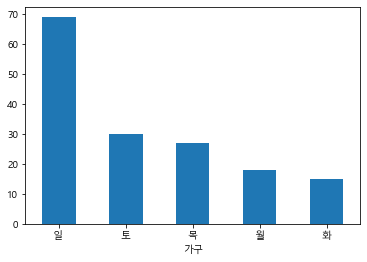

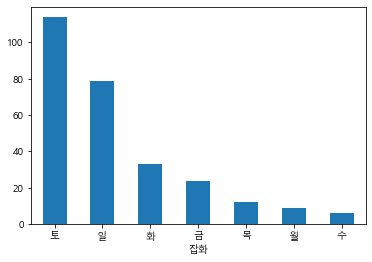

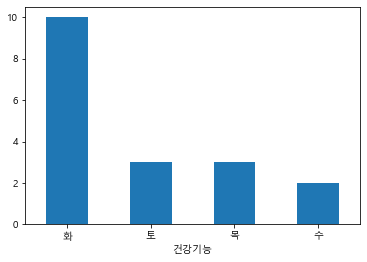

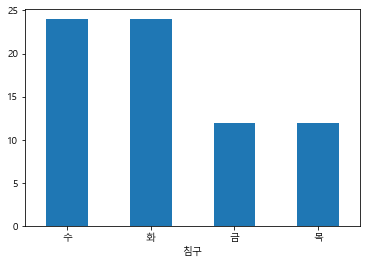

In [268]:
ratio25 = int(len(평가데이터) * 0.25)
for item in 평가데이터.상품군.unique():
    plt.figure()
    temp=평가데이터[평가데이터.상품군 == item].sort_values(by='취급액', ascending=False).요일[:ratio25].value_counts()
    temp.rename({0:'월',1:'화',2:'수',3:'목',4:'금',5:'토',6:'일'},axis=0,inplace=True)
    temp.plot(kind='bar')
    plt.xticks(rotation=0)
    plt.xlabel(item)
    plt.savefig('data/{}요일.png'.format(item))